In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
np.random.seed(42)




def sigmoid(Z):
    """
    Implements sigmoid non linear activation to linear output
    Z-> linear output
    """
    Z = np.clip(Z, -500, 500)
    A=1/(1+np.exp(-Z))
    cache=Z
    return A,cache

def relu(Z):
    """
    Implements relu non linear activation to linear output
    Z-> linear output
    """
    A=np.maximum(0,Z)
    cache=Z
    return A,cache

def tanh(Z):
    """
    Implements tanh non linear activation to linear output
    Z-> linear output
    """
    A=np.tanh(Z)
    cache=Z
    return A,cache

def initialize_parameters(layer_dims):
    """ 
    "layer dims" is a list consiting of number of input features and hidden units in each layer
    initalize_parameters() initializes parameters of all hidden layers 

    >>> initalize_parameters([4,10,15,25,10])
            return parameters
    """
    
    np.random.seed(42)
    L=len(layer_dims)
    parameters={}

    
    for i in range(1,L):
        
        parameters["W"+str(i)]=np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(2/layer_dims[i-1])
        parameters["b"+str(i)]=np.zeros((layer_dims[i],1))
        
        assert(parameters["W"+str(i)]).shape==(layer_dims[i],layer_dims[i-1])
        assert(parameters["b"+str(i)]).shape==(layer_dims[i],1)
        
    return parameters
def linear_activation_layer(A_prev,W,b,activation):

    """
    linear_activation_layer has four parameters X,W,b,activatuion
    A_prev-> input feature matrix
    W-> weight matirx
    b-> bias matrix
    activation-> applied non-linearity
    
    """
    Z=np.matmul(W,A_prev)+b
    linear_cache=(A_prev,W,b)
    
    if activation=="relu":
        A,activation_cache=relu(Z)
        
    elif activation=="sigmoid":
        A,activation_cache=sigmoid(Z)
        
    elif activation=="tanh":
        A,activation_cache=tanh(Z)
        
    cache=(linear_cache,activation_cache)
    assert(Z.shape==A.shape)
    assert(A.shape==(W.shape[0],A_prev.shape[1]))
    return A,cache    
def L_layer_deep_forward_layer(X,parameters):
    """ 
    L_layer_deep_forward_layer implements forward propagation part of Neural Netwrok
    X -> input feature matrix
    parameters -> A set containing all weight matrix and bias vector
    
    """

    
    L=len(parameters)//2
    A_in=X
    caches=[]
    
    for i in range(1,L):
        A_out,cache=linear_activation_layer(A_in,parameters["W"+str(i)],parameters["b"+str(i)],"relu")
        A_in=A_out
        caches.append(cache)
        
    A_L,cache=linear_activation_layer(A_in,parameters["W"+str(L)],parameters["b"+str(L)],"sigmoid")
    caches.append(cache)
    
    return A_L,caches

def compute_cost(y,y_pred):
    """
    Implement the binary crossntropy function 
    y-> target label
    y_pred-> predicted label
    
    """
    loss=-(y*np.log(y_pred+1e-15)+(1-y)*np.log(1-y_pred+1e-15))
    
    cost=np.mean(loss)
    cost=np.squeeze(cost)
    return cost
def linear_backward(dZ,linear_cache):
    """
    Implement 'single layer' linear backpropagation 
    dZ-> gradient of cost function w.r.t to linear output
    cache-> it is a tuple coming from linear activation layer 
    
    """
    m=dZ.shape[1]
    A_prev,W,b=linear_cache
    
    dW=np.matmul(dZ,A_prev.T)/m
    db=np.mean(dZ,axis=1,keepdims=True)
    dA_prev=np.matmul(W.T,dZ)
    
    return dW,db,dA_prev
def sigmoid_backward(dA,activation_cache):
    Z=activation_cache
    
    Z = np.clip(Z, -500, 500)
    A=1/(1+np.exp(-Z))
 
    return dA*A*(1-A)

def relu_backward(dA,activation_cache):
    Z=activation_cache
    return dA*np.where(Z>0,1,0)

def tanh_backward(dA,activation_cache):
    Z=activation_cache
    return dA*(1-np.tanh(Z)**2)

def linear_activation_backward(dA,cache,activation):
    linear_cache,activation_cache=cache
    
    if activation=="relu":
        dZ=relu_backward(dA,activation_cache)
        
    elif activation=="sigmoid":
        dZ=sigmoid_backward(dA,activation_cache)
        
        
    elif activation=="tanh":
        dZ=tanh_backward(dA,activation_cache)
    
    dW,db,dA_prev=linear_backward(dZ,linear_cache)  
    return dW,db,dA_prev


def L_layer_backward(A_L,y,caches):
    grads={}
    L=len(caches)
    cache=caches[L-1]
    m=y.shape[0]
    
    dAL=(-np.divide(y,A_L+1e-15)+np.divide(1-y,1-A_L+1e-15))
    grads["dW"+str(L)],grads["db"+str(L)],grads["dA"+str(L-1)]=linear_activation_backward(dAL,cache,"sigmoid")
 
    
    for i in reversed(range(L-1)):
        
        cache=caches[i]
     
        grads["dW"+str(i+1)],grads["db"+str(i+1)],grads["dA"+str(i)]=linear_activation_backward(grads["dA"+str(i+1)],cache,"relu")
        
    
    return grads
def update_parameters(parameters,grads,learning_rate):
    L=len(parameters)//2
    for i in range (L):
        parameters["W"+str(i+1)]-=learning_rate*grads["dW"+str(i+1)]
        parameters["b"+str(i+1)]-=learning_rate*grads["db"+str(i+1)]
    return parameters
def accuracy_of_model(X,y,parameters):
    m=y.shape[1]
    y_pred,cache= L_layer_deep_forward_layer(X,parameters)
    y_pred=(y_pred[0,:]>0.5).astype(int).reshape(1,-1)
    count=np.sum(y_pred[0,:]==y[0,:])
    accuracy=count/m

    return (accuracy)
def random_mini_batches(X,y,mini_batch_size,seed):
    np.random.seed(seed)
    mini_batches=[]
    m=X.shape[1]
    
    permutation=list(np.random.permutation(m))
    random_X=X[:,permutation]
    random_y=y[:,permutation]
    
    num_complete_batch=(m//mini_batch_size)
    
    for k in range(num_complete_batch):
        mini_batch_X=random_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_y=random_y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        
        batch=(mini_batch_X,mini_batch_y)
        mini_batches.append(batch)
        
    if(m%mini_batch_size!=0):
        mini_batch_X=random_X[:,num_complete_batch*mini_batch_size:]
        mini_batch_y=random_y[:,num_complete_batch*mini_batch_size:]
        batch=(mini_batch_X,mini_batch_y)
        mini_batches.append(batch)
        
    return mini_batches
def initialize_velocity(parameters):
    L=len(parameters)//2
    v={}
    for i in range(L):
        v["dW"+str(i+1)]=np.zeros((parameters["W"+str(i+1)].shape[0],parameters["W"+str(i+1)].shape[1]))
        v["db"+str(i+1)]=np.zeros((parameters["b"+str(i+1)].shape[0],parameters["b"+str(i+1)].shape[1]))
    return v

def update_parameters_with_momentum(parameters,grads,v,beta,learning_rate):
    L=len(parameters)//2
    for l in range(L):
        v["dW"+str(l+1)]=beta* v["dW"+str(l+1)] + (1-beta)* grads["dW"+str(l+1)]
        v["db"+str(l+1)]=beta* v["db"+str(l+1)] + (1-beta)* grads["db"+str(l+1)]
        
        parameters["W"+str(l+1)]-=learning_rate*v["dW"+str(l+1)]
        parameters["b"+str(l+1)]-=learning_rate*v["db"+str(l+1)]
    return parameters,v

def initialize_Adam(parameters):
    L=len(parameters)//2
    v={}
    s={}
    for l in range(L):
        v["dW"+str(l+1)]=np.zeros((parameters["W"+str(l+1)].shape[0], parameters["W"+str(l+1)].shape[1]))
        v["db"+str(l+1)]=np.zeros((parameters["b"+str(l+1)].shape[0], parameters["b"+str(l+1)].shape[1]))

        s["dW"+str(l+1)]=np.zeros((parameters["W"+str(l+1)].shape[0], parameters["W"+str(l+1)].shape[1]))
        s["db"+str(l+1)]=np.zeros((parameters["b"+str(l+1)].shape[0], parameters["b"+str(l+1)].shape[1]))
    return v,s

def update_parameters_with_adam(parameters,grads,v,s,t,learning_rate=0.01,beta1=0.9,beta2=0.999,epsilon=1e-8):
    
    v_corrected={}
    s_corrected={}
    
    L=len(parameters)//2
    
    for l in range(L):
        v["dW"+str(l+1)]=beta1*v["dW"+str(l+1)]+(1-beta1)*grads["dW"+str(l+1)]
        v["db"+str(l+1)]=beta1*v["db"+str(l+1)]+(1-beta1)*grads["db"+str(l+1)]
        
        s["dW"+str(l+1)]=beta2*s["dW"+str(l+1)]+(1-beta2)*np.square(grads["dW"+str(l+1)])
        s["db"+str(l+1)]=beta2*s["db"+str(l+1)]+(1-beta2)*np.square(grads["db"+str(l+1)])

        v_corrected["dW"+str(l+1)]=v["dW"+str(l+1)]/(1-beta1**t)
        v_corrected["db"+str(l+1)]=v["db"+str(l+1)]/(1-beta1**t)
        s_corrected["dW"+str(l+1)]=s["dW"+str(l+1)]/(1-beta2**t)
        s_corrected["db"+str(l+1)]=s["db"+str(l+1)]/(1-beta2**t)

        parameters["W"+str(l+1)]-=learning_rate*v_corrected["dW"+str(l+1)]/np.sqrt(s_corrected["dW"+str(l+1)]+epsilon)
        parameters["b"+str(l+1)]-=learning_rate*v_corrected["db"+str(l+1)]/np.sqrt(s_corrected["db"+str(l+1)]+epsilon)
    return parameters,v,s

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

X, y = load_breast_cancer(return_X_y=True)

scaler = StandardScaler()
X = scaler.fit_transform(X)

y = y.reshape(-1, 1)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = X_train.T  
y_train = y_train.T  
X_test = X_test.T
y_test = y_test.T


In [13]:
layers_dims = [30, 16, 8, 1]


The number of training example is: 455
The size of mini batch for each epoch is: 64
cost after epoch 0: 0.009566606653678159
cost after epoch 100: 2.107857495202655e-06
cost after epoch 200: 4.255470055597997e-07
cost after epoch 300: 1.935041843214466e-07
cost after epoch 400: 8.478382556579333e-08
cost after epoch 500: 4.694417497679132e-08
cost after epoch 600: 8.862970797273003e-08
cost after epoch 700: 1.535224563475681e-08
cost after epoch 800: 9.832160847829792e-09
cost after epoch 900: 6.601801543296858e-09


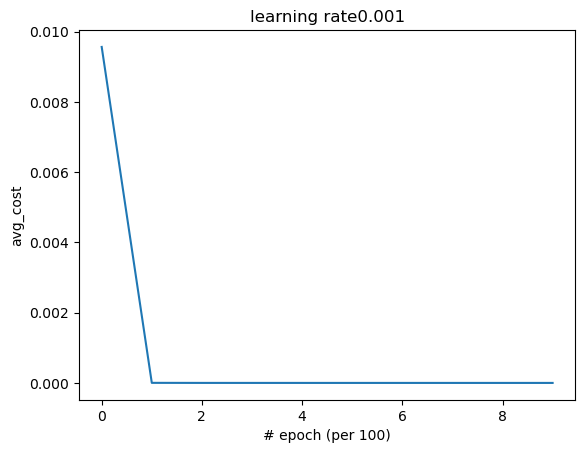

In [15]:
parameters=model(X_train,y_train,layers_dims,"Adam",learning_rate=1e-3,mini_batch_size=64,beta=0.9,beta1=0.9,beta2=0.999,epsilon=1e-8,num_epochs=1000,print_cost=True)

In [46]:

def model(X,y,layer_dims,optimizer,learning_rate=0.0007,mini_batch_size=64,beta=0.9,beta1=0.9,beta2=0.999,epsilon=1e-8,num_epochs=10000,print_cost=True):

    parameters=initialize_parameters(layer_dims)
    L=len(parameters)//2
    costs=[]
    t=0
    seed=1
    m=y.shape[1]
    
    print(f"The number of training example is: {m}")
    print(f"The size of mini batch for each epoch is: {mini_batch_size}")
    
    
    if optimizer=="GD":
        pass
    elif optimizer=="momentum":
        v=initialize_velocity(parameters)
    elif optimizer=="Adam":
        v,s=initialize_Adam(parameters)
    
    for i in range(num_epochs):
        seed=seed+1
        mini_batches=random_mini_batches(X,y,mini_batch_size,seed)
        total_cost=0

        for mini_batch in mini_batches:
            random_X,random_y=mini_batch
            
            AL,caches=L_layer_deep_forward_layer(random_X,parameters)
            total_cost+=compute_cost(random_y,AL)
            grads=L_layer_backward(AL,random_y,caches)

            if optimizer=="GD":
                parameters=update_parameters(parameters,grads,learning_rate)
                
            elif optimizer=="momentum":
                parameters,v=update_parameters_with_momentum(parameters,grads,v,beta,learning_rate)
                
            elif optimizer=="Adam":
                t+=1
                parameters,v,s=update_parameters_with_adam(parameters,grads,v,s,t,learning_rate=0.01,beta1=0.9,beta2=0.999,epsilon=1e-8)
        cost_avg=total_cost/m
            
        if i%10==0:
            costs.append(cost_avg)
        if i%10==0 and print_cost:
            print(f"cost after epoch {i}: {cost_avg}")
                
    plt.plot(costs)
    plt.xlabel("# epoch (per 100)")
    plt.ylabel("avg_cost")
    plt.title("learning rate" +str(learning_rate))
    plt.show()
    return parameters

In [18]:

train_set_error= accuracy_of_model(X_train,y_train,parameters)
test_set_error= accuracy_of_model(X_test,y_test,parameters)

print(train_set_error)
print(test_set_error)

1.0
0.9649122807017544


The number of training example is: 455
The size of mini batch for each epoch is: 64
cost after epoch 0: 0.0173641445857085
cost after epoch 100: 0.005989875818402151
cost after epoch 200: 0.00478461741090923
cost after epoch 300: 0.0036662493773156053
cost after epoch 400: 0.002853018931395218
cost after epoch 500: 0.002766348133113488
cost after epoch 600: 0.003206320020148763
cost after epoch 700: 0.0014914599779748366
cost after epoch 800: 0.0013697308886950234
cost after epoch 900: 0.0012224748595858418


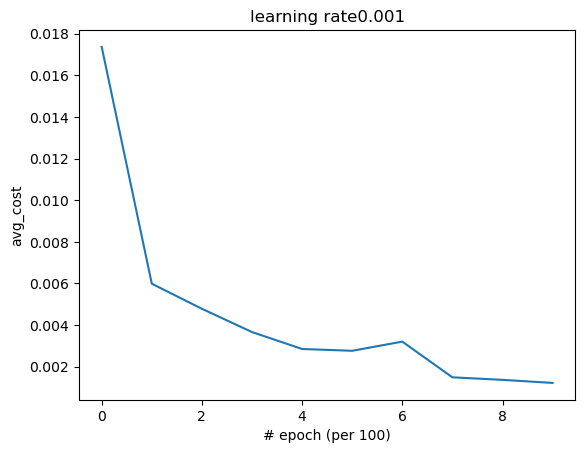

In [19]:
parameters=model(X_train,y_train,layers_dims,"momentum",learning_rate=1e-3,mini_batch_size=64,beta=0.9,beta1=0.9,beta2=0.999,epsilon=1e-8,num_epochs=1000,print_cost=True)

The number of training example is: 455
The size of mini batch for each epoch is: 64
cost after epoch 0: 0.01724041298205099
cost after epoch 100: 0.005966437622171336
cost after epoch 200: 0.004771706522305874
cost after epoch 300: 0.0036559891917212115
cost after epoch 400: 0.002845742335169891
cost after epoch 500: 0.0027632374555810807
cost after epoch 600: 0.003194533197814261
cost after epoch 700: 0.001488917109758518
cost after epoch 800: 0.001367092860475013
cost after epoch 900: 0.001220182965754464


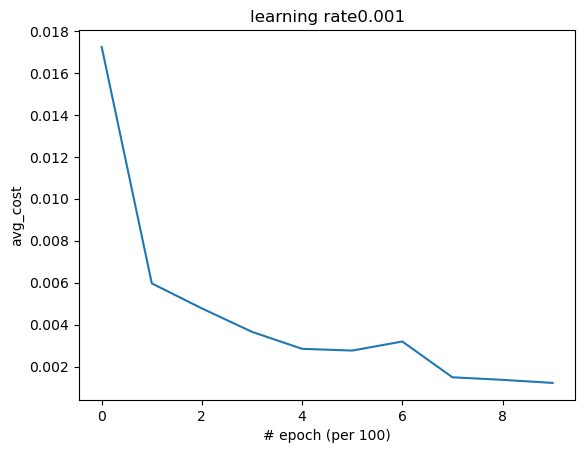

In [20]:
parameters=model(X_train,y_train,layers_dims,"GD",learning_rate=1e-3,mini_batch_size=64,beta=0.9,beta1=0.9,beta2=0.999,epsilon=1e-8,num_epochs=1000,print_cost=True)

In [21]:
train_set_error= accuracy_of_model(X_train,y_train,parameters)
test_set_error= accuracy_of_model(X_test,y_test,parameters)

print(train_set_error)
print(test_set_error)

0.9824175824175824
0.9736842105263158


In [4]:
def binaryCrossentropyRegularized(y,AL,lambd,parameters):
    m=y.shape[1]
    regularized_term=0
    L=len(parameters)//2
    for i in range(L):
        regularized_term+=np.sum(parameters["W"+str(i+1)]**2)
    regularized_term*=lambd/(2*m)
   
    cost_term=-y*np.log(AL+1e-8)-(1-y)*np.log(1-AL+1e-8)
    cost_term=np.sum(cost_term)
    return cost_term/m+regularized_term




def linear_backward_regularized(dZ,linear_cache,lambd):
    m=dZ.shape[1]
    A_prev,W,b=linear_cache

    dW=np.matmul(dZ,A_prev.T)/m+lambd*W/m
    db=np.mean(dZ,axis=1,keepdims=True)
    dA_prev=np.matmul(W.T,dZ)
    return dW,db,dA_prev
    

def linear_activation_backward_regularized(dA,cache,activation,lambd):
    linear_cache,activation_cache=cache
    if activation=="relu":
        dZ=relu_backward(dA,activation_cache)
        
    elif activation=="sigmoid":
        dZ=sigmoid_backward(dA,activation_cache)
        
        
    elif activation=="tanh":
        dZ=tanh_backward(dA,activation_cache)
    dW,db,dA_prev=linear_backward_regularized(dZ,linear_cache,lambd)
    return dW,db,dA_prev

def L_layer_backward_regularized(A_L,y,caches,lambd):
    m=y.shape[1]
    L=len(caches)
    cache=caches[L-1]
    grads={}
    
    dA=-y/(A_L+1e-8)+(1-y)/(1-A_L+1e-8)
    grads["dW"+str(L)],grads["db"+str(L)],grads["dA"+str(L-1)]=linear_activation_backward_regularized(dA,cache,"sigmoid",lambd)
    for i in reversed(range(1,L)):
        cache=caches[i-1]
        grads["dW"+str(i)],grads["db"+str(i)],grads["dA"+str(i-1)]=linear_activation_backward_regularized(grads["dA"+str(i)],cache,"relu",lambd)
    return grads

def update_parameters_regularized(parameters,grads,learning_rate,lambd):
    L=len(parameters)//2
    for i in range(L):
        parameters["W"+str(i+1)]-=learning_rate*grads["dW"+str(i+1)]
        parameters["b"+str(i+1)]-=learning_rate*grads["db"+str(i+1)]
    return parameters

def L_layer_model_regularized(X,y,layer_dims,learning_rate,iteration,lambd,print_cost=False):
    parameters=initialize_parameters(layer_dims)
    costs=[]
    for i in range(iteration):
        AL,caches= L_layer_deep_forward_layer(X,parameters)
        cost=binaryCrossentropyRegularized(y,AL,lambd,parameters)
        grads=L_layer_backward_regularized(AL,y,caches,lambd)
        parameters=update_parameters_regularized(parameters,grads,learning_rate,lambd)
        if print_cost and i%100==0:
            costs.append(cost)
            print(f"Cost after iteration {i}: {cost}")
    return parameters,costs

Cost after iteration 0: 0.9814327886214709
Cost after iteration 100: 0.3741441938974781
Cost after iteration 200: 0.26456248078981254
Cost after iteration 300: 0.20491025705026977
Cost after iteration 400: 0.16736813195736044
Cost after iteration 500: 0.141115727878053
Cost after iteration 600: 0.12118249420433823
Cost after iteration 700: 0.10551853158811264
Cost after iteration 800: 0.09382339017603603
Cost after iteration 900: 0.0852603603779967
Cost after iteration 1000: 0.07867194335626175
Cost after iteration 1100: 0.07312592336077929
Cost after iteration 1200: 0.06839204732557497
Cost after iteration 1300: 0.06464830868491281
Cost after iteration 1400: 0.06156107129140059
Cost after iteration 1500: 0.058857670460363
Cost after iteration 1600: 0.056467595224246984
Cost after iteration 1700: 0.0543319799403678
Cost after iteration 1800: 0.05243638458482516
Cost after iteration 1900: 0.05070526667291582
Cost after iteration 2000: 0.049112207584928076
Cost after iteration 2100: 0.04

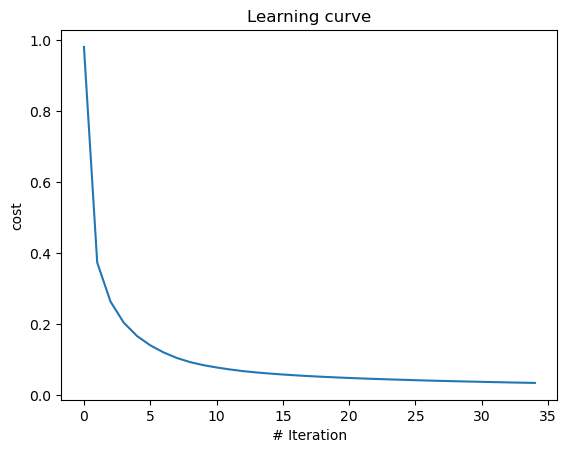

In [24]:
parameters,costs=L_layer_model_regularized(X_train,y_train,(30,16,8,1),0.0075,3500,0.1,print_cost=True)

plt.plot(costs)
plt.xlabel("# Iteration")
plt.ylabel("cost")
plt.title("Learning curve")
plt.show()


In [25]:
train_set_error= accuracy_of_model(X_train,y_train,parameters)
test_set_error= accuracy_of_model(X_test,y_test,parameters)

print(train_set_error)
print(test_set_error)

0.9912087912087912
0.9824561403508771


In [5]:
def linear_activation_layer_dropout(A_prev,W,b,activation,keep_prop):
    Z=np.matmul(W,A_prev)+b
    linear_cache=(A_prev,W,b)
    if activation=="relu":
        A,activation_cache=relu(Z)
        
    elif activation=="sigmoid":
        A,activation_cache=sigmoid(Z)
        
    elif activation=="tanh":
        A,activation_cache=tanh(Z)
    D=(np.random.rand(A.shape[0],A.shape[1])<keep_prop).astype(int)

    A=A*D
    A/=keep_prop
 
    
    cache=(linear_cache,activation_cache,D)
    return A,cache

def L_layer_deep_forward_layer_dropout(X,parameters,keep_prop):
    L=len(parameters)//2
    A_prev=X
    caches=[]
    for i in range(L-1):
        A,cache=linear_activation_layer_dropout(A_prev,parameters["W"+str(i+1)],parameters["b"+str(i+1)],"relu",keep_prop)
        caches.append(cache)
        A_prev=A
        
    A,cache=linear_activation_layer_dropout(A_prev,parameters["W"+str(L)],parameters["b"+str(L)],"sigmoid",1)
    caches.append(cache)
    return A,caches

def linear_activation_backward_dropout(dA,cache,activation,keep_prop):
    linear_cache,activation_cache,D=cache
    dA=dA*D/keep_prop
    if activation=="relu":
        dZ=relu_backward(dA,activation_cache)
        
    elif activation=="sigmoid":
        dZ=sigmoid_backward(dA,activation_cache)
        
        
    elif activation=="tanh":
        dZ=tanh_backward(dA,activation_cache)
    
    dW,db,dA_prev=linear_backward(dZ,linear_cache)  
    return dW,db,dA_prev  


def L_layer_backward_dropout(A_L,y,caches,keep_prop):
    grads={}
    L=len(caches)
    cache=caches[L-1]
    m=y.shape[1]
    
    dAL=(-np.divide(y,A_L+1e-8)+np.divide(1-y,1-A_L+1e-8))/m
    grads["dW"+str(L)],grads["db"+str(L)],grads["dA"+str(L-1)]=linear_activation_backward_dropout(dAL,cache,"sigmoid",1)
 
    
    for i in reversed(range(L-1)):
        
        cache=caches[i]
     
        grads["dW"+str(i+1)],grads["db"+str(i+1)],grads["dA"+str(i)]=linear_activation_backward_dropout(grads["dA"+str(i+1)],cache,"relu",keep_prop)
        
    
    return grads

def L_layer_model_dropout(X,y,layer_dims,learning_rate,iterations,keep_prop,print_cost=False):
    parameters=initialize_parameters(layer_dims)
    costs=[]
    for i in range(iterations):
        AL,caches= L_layer_deep_forward_layer_dropout(X,parameters,keep_prop)
        cost=compute_cost(y,AL)
        grads=L_layer_backward_dropout(AL,y,caches,keep_prop)
        parameters=update_parameters(parameters,grads,learning_rate)
        costs.append(cost)
        if print_cost and i % 100 == 0:
            print(f"Cost after iteration {i}: {cost}")
            if(i>0 and abs(costs[i]-costs[i-1])<1e-5):
                break
    return parameters,costs

Cost after iteration 0: 1.2821362169500476
Cost after iteration 100: 1.3437635598638602
Cost after iteration 200: 1.2513169461451683
Cost after iteration 300: 1.411831160029004
Cost after iteration 400: 1.2795602814681923
Cost after iteration 500: 1.1443061340710778
Cost after iteration 600: 1.2264386173283766
Cost after iteration 700: 1.3084817873446104
Cost after iteration 800: 1.3826790204871646
Cost after iteration 900: 1.2839712418074898
Cost after iteration 1000: 1.1732104224443962
Cost after iteration 1100: 1.1811631883734524
Cost after iteration 1200: 1.2663627033925722
Cost after iteration 1300: 1.2437252517078106
Cost after iteration 1400: 1.1939498473204846
Cost after iteration 1500: 1.168996587402616
Cost after iteration 1600: 1.2727799269699787
Cost after iteration 1700: 1.176940539584941
Cost after iteration 1800: 1.2621097246805288
Cost after iteration 1900: 1.2137489005991131
Cost after iteration 2000: 1.2170608921318813
Cost after iteration 2100: 1.107222894709707
Cost

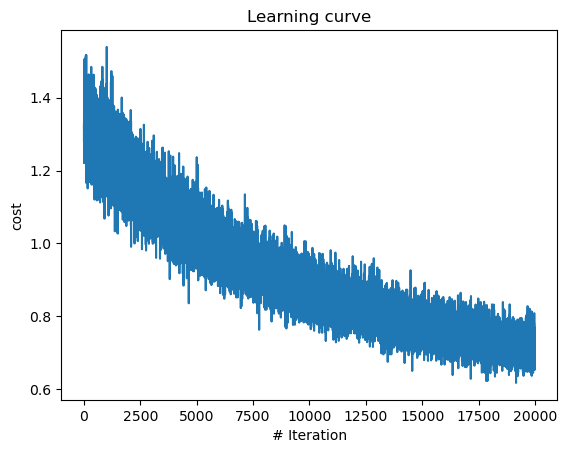

0.7648351648351648
0.7543859649122807


In [29]:

    
    parameters,costs=L_layer_model_dropout(X_train,y_train,layers_dims,0.01,20000,0.5,print_cost=True)

    
    plt.plot(costs)
    plt.xlabel("# Iteration")
    plt.ylabel("cost")
    plt.title("Learning curve")
    plt.show()

  


    train_set_error= accuracy_of_model(X_train,y_train,parameters)
    test_set_error= accuracy_of_model(X_test,y_test,parameters)

    print(train_set_error)
    print(test_set_error)

In [29]:
import numpy as np
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

train_filter = np.where((y_train == 0) | (y_train == 1))
test_filter = np.where((y_test == 0) | (y_test == 1))

X_train_01 = X_train[train_filter]
y_train_01 = y_train[train_filter]

X_test_01 = X_test[test_filter]
y_test_01 = y_test[test_filter]


X_train_01 = X_train_01 / 255.0
X_test_01 = X_test_01 / 255.0


X_train_01 = X_train_01.reshape(X_train_01.shape[0], -1).T 
X_test_01 = X_test_01.reshape(X_test_01.shape[0], -1).T

y_train_01 = y_train_01.reshape(1, -1)  
y_test_01 = y_test_01.reshape(1, -1)


In [34]:
print(y_train_01.shape)

(1, 12665)


The number of training example is: 12665
The size of mini batch for each epoch is: 64
cost after epoch 0: 0.00032009423731019785


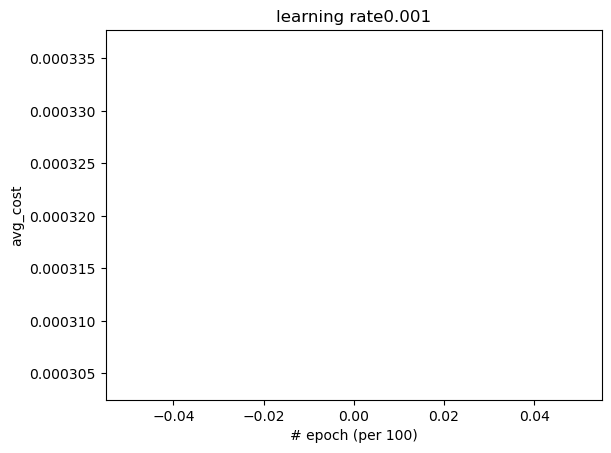

In [8]:
parameters=model(X_train_01,y_train_01,layers_dims,"Adam",learning_rate=1e-3,mini_batch_size=64,beta=0.9,beta1=0.9,beta2=0.999,epsilon=1e-8,num_epochs=100,print_cost=True)

In [7]:
layers_dims=[784,128,64,32,1]

In [12]:


  


train_set_error= accuracy_of_model(X_train_01,y_train_01,parameters)
test_set_error= accuracy_of_model(X_test_01,y_test_01,parameters)

print(train_set_error)
print(test_set_error)

1.0
1.0


In [30]:
y_pred,caches=L_layer_deep_forward_layer(X_train_01,parameters)

In [31]:
print(y_pred)

[[1.92240060e-49 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  2.40278181e-38 1.00000000e+00]]


In [32]:
y_pred=(y_pred>0.5).astype(int)
count=np.sum(y_pred!=y_train_01)

In [33]:
print(count)

0


In [34]:
y_pred,caches=L_layer_deep_forward_layer(X_test_01,parameters)

In [36]:
y_pred=(y_pred>0.5).astype(int)
count=np.sum(y_pred!=y_test_01)

In [37]:
print(count)

0


In [41]:

train_strings = np.array([" ".join(x.astype(str)) for x in X_train_01])
test_strings = np.array([" ".join(x.astype(str)) for x in X_test_01])

duplicates = np.intersect1d(train_strings, test_strings).shape[0]
print("Duplicate samples:", duplicates)


Duplicate samples: 0


In [42]:
print(X_test_01.shape)

(784, 2115)


In [97]:
import numpy as np
from tensorflow.keras.datasets import mnist


(X_train, y_train), (X_test, y_test) = mnist.load_data()

selected_classes = [3, 8]
train_filter = np.isin(y_train, selected_classes)
test_filter = np.isin(y_test, selected_classes)

X_train_01 = X_train[train_filter]
y_train_01 = y_train[train_filter]

X_test_01 = X_test[test_filter]
y_test_01 = y_test[test_filter]
X_train_01 = X_train_01 / 255.0
X_test_01 = X_test_01 / 255.0
X_train_01 = X_train_01.reshape(X_train_01.shape[0], -1).T
X_test_01 = X_test_01.reshape(X_test_01.shape[0], -1).T


y_train_01 = (y_train_01 == selected_classes[1]).astype(int).reshape(1, -1)
y_test_01 = (y_test_01 == selected_classes[1]).astype(int).reshape(1, -1)


In [90]:
print(y_train_01)

[[0 0 0 ... 1 0 1]]


The number of training example is: 11379
The size of mini batch for each epoch is: 64
cost after epoch 0: 0.0010286461175266807
cost after epoch 10: 7.069596391731169e-05
cost after epoch 20: 9.186451709031613e-09
cost after epoch 30: 2.4175537438894453e-09
cost after epoch 40: 9.067897098856854e-10


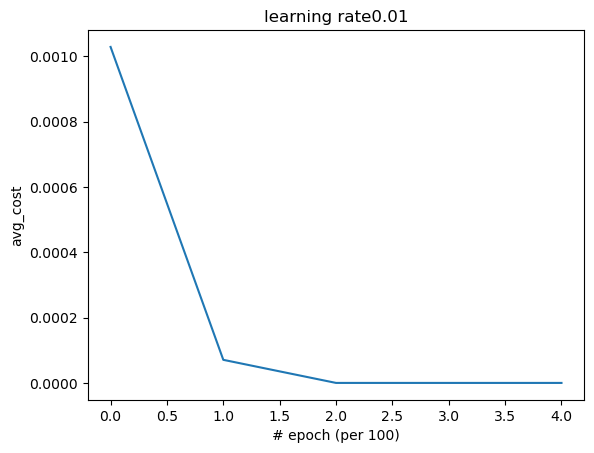

In [101]:
parameters=model(X_train_01,y_train_01,layers_dims,"Adam",learning_rate=1e-2,mini_batch_size=64,beta=0.9,beta1=0.9,beta2=0.999,epsilon=1e-8,num_epochs=50,print_cost=True)

In [102]:


train_set_error= accuracy_of_model(X_train_01,y_train_01,parameters)
test_set_error= accuracy_of_model(X_test_01,y_test_01,parameters)

print(train_set_error)
print(test_set_error)

1.0
0.9994802494802495


In [100]:
import numpy as np
from tensorflow.keras.datasets import mnist


(X_train, y_train), (X_test, y_test) = mnist.load_data()

selected_classes = [2, 5]
train_filter = np.isin(y_train, selected_classes)
test_filter = np.isin(y_test, selected_classes)

X_train_01 = X_train[train_filter]
y_train_01 = y_train[train_filter]

X_test_01 = X_test[test_filter]
y_test_01 = y_test[test_filter]
X_train_01 = X_train_01 / 255.0
X_test_01 = X_test_01 / 255.0
X_train_01 = X_train_01.reshape(X_train_01.shape[0], -1).T
X_test_01 = X_test_01.reshape(X_test_01.shape[0], -1).T


y_train_01 = (y_train_01 == selected_classes[1]).astype(int).reshape(1, -1)
y_test_01 = (y_test_01 == selected_classes[1]).astype(int).reshape(1, -1)

In [52]:
print(y_train_01)

[[3 3 3 ... 8 3 8]]


In [117]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


train_filter = np.isin(y_train, [2, 4])
test_filter = np.isin(y_test, [2, 4])

X_train, y_train = X_train[train_filter], y_train[train_filter]
X_test, y_test = X_test[test_filter], y_test[test_filter]


X_train = X_train.reshape(X_train.shape[0], -1).T / 255.
X_test = X_test.reshape(X_test.shape[0], -1).T / 255.
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)
selected_classes = [2, 4]
y_train = (y_train == selected_classes[1]).astype(int)
y_test = (y_test == selected_classes[1]).astype(int)

The number of training example is: 12000
The size of mini batch for each epoch is: 64
cost after epoch 0: 0.006793345085343523
cost after epoch 10: 0.004009252410122304
cost after epoch 20: 0.0033856355982992956
cost after epoch 30: 0.0030461359622063313
cost after epoch 40: 0.0027199575655394827
cost after epoch 50: 0.0026502538054117434
cost after epoch 60: 0.0024876392772455467
cost after epoch 70: 0.002140454617251533
cost after epoch 80: 0.0020769338280501623
cost after epoch 90: 0.0017967065427889877


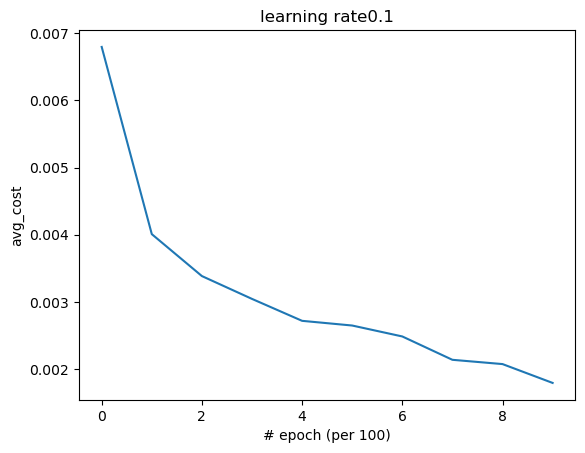

In [118]:
parameters=model(X_train,y_train,layers_dims,"Adam",learning_rate=0.1,mini_batch_size=64,beta=0.9,beta1=0.9,beta2=0.999,epsilon=1e-8,num_epochs=100,print_cost=True)

In [86]:
print(y_train)

[[7 5 5 ... 7 5 5]]


In [57]:
layers_dims=[784,128,64,32,16,1]

In [59]:
print(X_train.shape)

(784, 12000)


In [60]:
print(y_train.shape)

(12000, 1)


In [119]:
train_set_error= accuracy_of_model(X_train,y_train,parameters)
test_set_error= accuracy_of_model(X_test,y_test,parameters)

print(train_set_error)
print(test_set_error)

0.95825
0.8845


In [65]:
import matplotlib.pyplot as plt

def plot_predictions(X, y_true, y_pred, label_names, correct=True, num_samples=5):
    """
    Plots a few examples where the model was correct or incorrect.
    """
    assert X.shape[0] == 784  
    
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    if correct:
        indices = np.where(y_true == y_pred)[0]
        title = "Correct Predictions"
    else:
        indices = np.where(y_true != y_pred)[0]
        title = "Incorrect Predictions"
    
    if len(indices) == 0:
        print("No samples to display.")
        return
    
    indices = np.random.choice(indices, size=min(num_samples, len(indices)), replace=False)
    
    plt.figure(figsize=(15, 4))
    for i, idx in enumerate(indices):
        image = X[:, idx].reshape(28, 28)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image, cmap="gray")
        plt.title(f"Pred: {label_names[y_pred[idx]]}\nTrue: {label_names[y_true[idx]]}")
        plt.axis("off")
    
    plt.suptitle(title, fontsize=16)
    plt.show()


In [108]:
plot_predictions(X_train, y_train, y_pred, label_names, correct=True, num_samples=5)

ValueError: operands could not be broadcast together with shapes (12000,) (2000,) 

In [67]:
print(y_pred.shape)

(1, 2115)


In [109]:
y_pred,caches=L_layer_deep_forward_layer(X_test,parameters)

In [112]:
label_names = {
    0: "sandal",
    1: "sneakers"
}


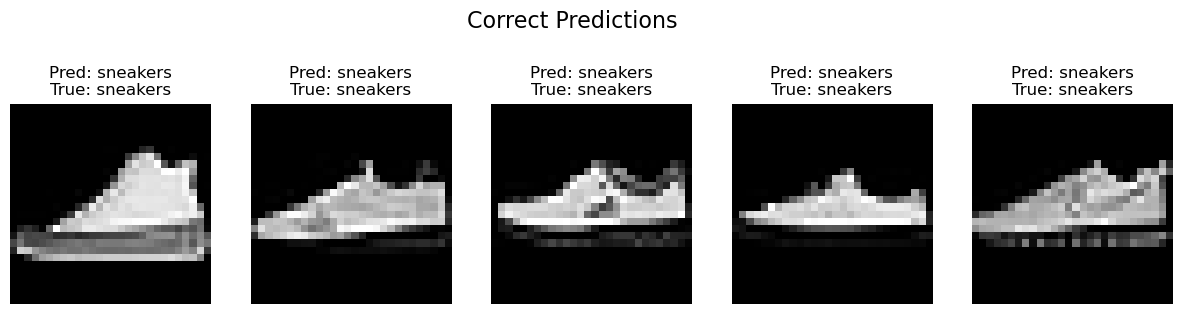

In [113]:
plot_predictions(X_test, y_test, y_pred, label_names, correct=True, num_samples=5)

In [74]:
print(y_train)

[[0 0 0 ... 1 1 0]]


In [115]:
def plot_predictions(X, y_true, y_pred, label_names, correct=True, num_samples=5):
    indices = np.arange(X.shape[1])
    np.random.shuffle(indices)

    shown = 0
    plt.figure(figsize=(15, 3))
    for idx in indices:
        if (y_pred[0, idx] == y_true[0, idx]) == correct:
            img = X[:, idx].reshape(28, 28)
            plt.subplot(1, num_samples, shown + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.title(f"Pred: {label_names[y_pred[0, idx]]}\nTrue: {label_names[y_true[0, idx]]}")
            shown += 1
            if shown >= num_samples:
                break
    plt.tight_layout()
    plt.show()



Correct Predictions:


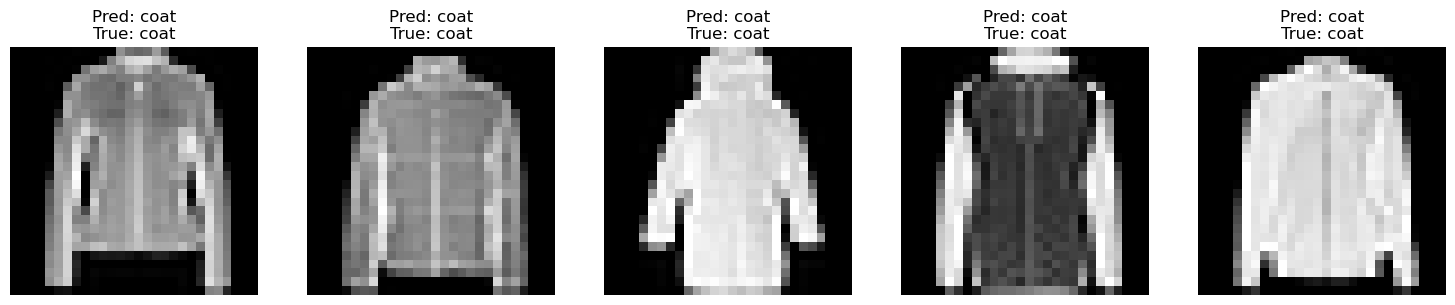

Incorrect Predictions:


C:\Users\akash kumar shaw\AppData\Local\Temp\ipykernel_20168\3880129113.py:17: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
C:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


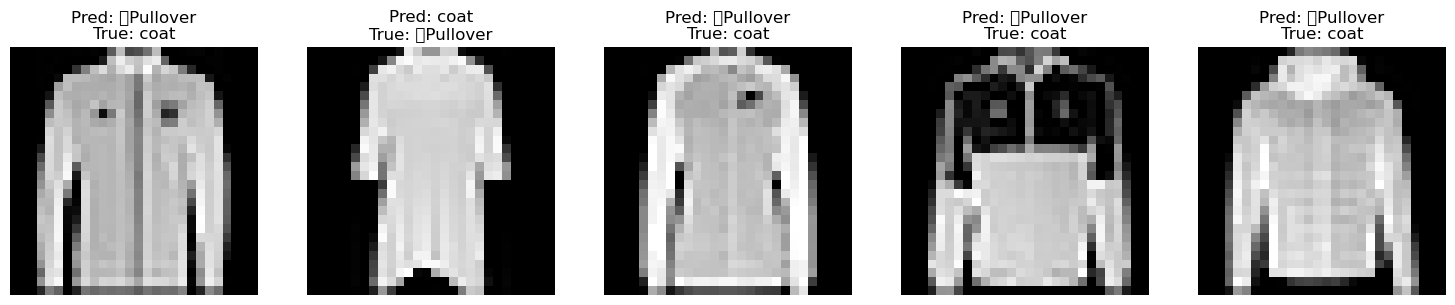

In [120]:
# Predict on test set
y_pred_test, _ = L_layer_deep_forward_layer(X_test, parameters)
y_pred_test = (y_pred_test > 0.5).astype(int)

# Label mapping
label_names = {0: "	Pullover", 1: "coat"}

# Plot correct predictions
print("Correct Predictions:")
plot_predictions(X_test, y_test, y_pred_test, label_names, correct=True, num_samples=5)

# Plot incorrect predictions
print("Incorrect Predictions:")
plot_predictions(X_test, y_test, y_pred_test, label_names, correct=False, num_samples=5)


The number of training example is: 768
The size of mini batch for each epoch is: 64


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 768 is different from 784)